In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd

csvPath = os.path.join('/content/drive/MyDrive/Term_Project/dog_cat_labels.csv')
df = pd.read_csv(csvPath)

print(df.head(10))
print(df.shape)

   Unnamed: 0      file_name label
0           0   dog.8011.jpg   dog
1           1   cat.5077.jpg   cat
2           2   dog.7322.jpg   dog
3           3   cat.2718.jpg   cat
4           4  cat.10151.jpg   cat
5           5   cat.3406.jpg   cat
6           6   dog.1753.jpg   dog
7           7   cat.4369.jpg   cat
8           8   cat.7660.jpg   cat
9           9   dog.5535.jpg   dog
(25000, 3)


In [3]:
print(df.columns)

labels = list()
for index, row in df.iterrows():
    labels.append(row['label'])
    
classes = []
[classes.append(x) for x in labels if x not in classes]
print(classes)

Index(['Unnamed: 0', 'file_name', 'label'], dtype='object')
['dog', 'cat']


In [7]:
# for cat-dog
!unzip /content/drive/MyDrive/Term_Project/train.zip 
# !unzip /content/drive/MyDrive/Term_Project/pet_animals.zip 
# for indoor-outdoor
# !unzip /content/drive/MyDrive/Term_Project/train.zip 


Archive:  /content/drive/MyDrive/Term_Project/train.zip
   creating: train/
  inflating: train/cat_7286.jpg      
replace __MACOSX/train/._cat_7286.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [21]:
training_data_path = '/content/' + 'train/'

/bin/bash: line 0: cd: training_data_path: No such file or directory
4


In [66]:
import PIL
from PIL import UnidentifiedImageError
import glob

imgs_ = glob.glob("/content/train/*.jpg")

for img in imgs_:
    try:
        img = PIL.Image.open(img)
  
        # img.verify()
        # img.load()
  
    except PIL.UnidentifiedImageError:
        print(img)
    # except Exception as e:
    #   print(img)
    #   print("An exception is raised:", e)

In [16]:
!ls training_data_path

ls: cannot access 'training_data_path': No such file or directory


Training device: 
Python 3 Google Compute Engine backend (GPU)


*   System RAM: 25.5 GB
*   GPU RAM: 15.0 GB
*   Disk: 166.8 GB




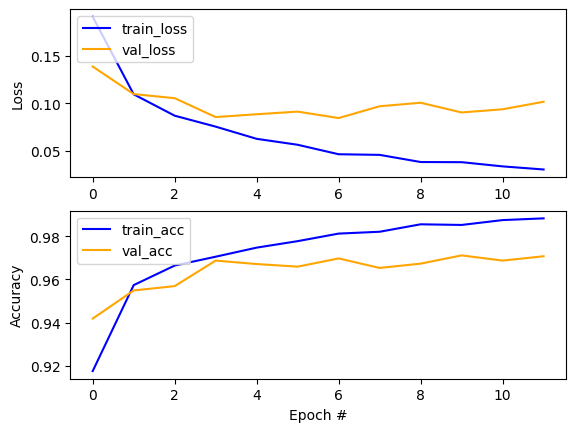

In [72]:
from matplotlib import pyplot as plt
#plot learning curves
def summarize_accuraccy_loss(history):
  # plot loss
  plt.subplot(211)
  # plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train_loss')
  plt.plot(history.history['val_loss'], color='orange', label='val_loss')
  plt.ylabel("Loss")
  plt.legend(loc="upper left")
  # plot accuracy
  plt.subplot(212)
  # plt.title('Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train_acc')
  plt.plot(history.history['val_accuracy'], color='orange', label='val_acc')
  plt.xlabel("Epoch #")
  plt.ylabel("Accuracy")
  plt.legend(loc="upper left")
  plt.show()
  plt.close()
summarize_accuraccy_loss(history)

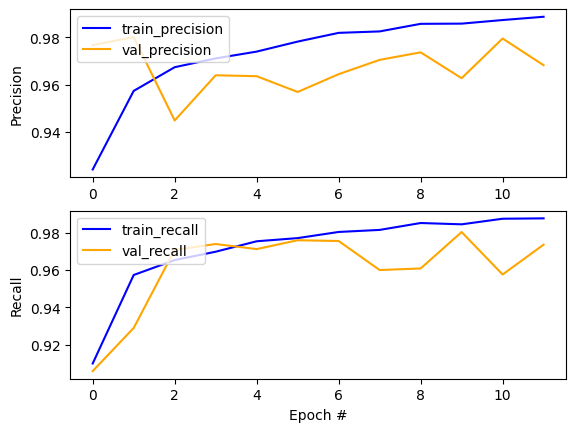

In [73]:
def summarize_precission_recall(history):
  # plot loss
  plt.subplot(211)
  # plt.title('Cross Entropy Loss')
  plt.plot(history.history['precision'], color='blue', label='train_precision')
  plt.plot(history.history['val_precision'], color='orange', label='val_precision')
  plt.ylabel("Precision")
  plt.legend(loc="upper left")
  # plot accuracy
  plt.subplot(212)
  # plt.title('Accuracy')
  plt.plot(history.history['recall'], color='blue', label='train_recall')
  plt.plot(history.history['val_recall'], color='orange', label='val_recall')
  plt.xlabel("Epoch #")
  plt.ylabel("Recall")
  plt.legend(loc="upper left")
  plt.show()
  # save plot to file
  # filename = sys.argv[0].split('/')[-1]
  # pyplot.savefig(filename + '_plot.png')
  plt.close()
summarize_precission_recall(history) 

In [3]:
"""
Some part of training code is taken from https://pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/
"""
import os
import numpy as np
import pandas as pd
import argparse
import random
import time
import pickle
import tensorflow as tf
import keras  # For building deep learning models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# Pre-trained models
from tensorflow.keras.applications import VGG16  # For using pre-trained models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator # For image data augmentation
from keras.models import Model
# from keras import metrics
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
# from utils import get_f1

IMG_SIZE = 224
BATCH_SIZE = 16

# Function to separate datasets into training and testing sets
def train_test_dataset(data, labels):
    # separate into train and test datasets uisng 80% for training and 20% for testing
    print("[INFO] Splitting images into train-test sets...")
    trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, random_state=42)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, testX, trainY, testY

# Defining CNN model based on VGG16
def define_model(labels):
    print("[INFO] Initializing model...")
    # include_top is to include the classifier layer; whether to include the 3 fully-connected layers at the top of the network
    base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (IMG_SIZE, IMG_SIZE, 3), classes=len(labels))
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    last_output = base_model.output
    x = GlobalAveragePooling2D()(last_output)
    x = Dense(512, activation = 'relu')(x)
    outputs = Dense(units=len(labels), activation = 'sigmoid')(x)
    # outputs = Dense(units=10, activation = 'sigmoid')(x)
    model = Model(inputs = base_model.inputs, outputs = outputs)
    # model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', get_f1])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
    return model

# create a one hot encoding for labels
def one_hot_encode(labels, mapping):
    # print("[INFO] One hot encoding...")
    # create empty vector
    encoding = np.zeros(len(mapping), dtype='uint8')
    # mark 1 for each label in the vector
    encoding[mapping[labels]] = 1
    return encoding

# Loading all images
# def load_images(path, file_mapping, label_mapping):
def load_images(args, file_mapping, label_mapping):
    print("[INFO] Loading images...")
    data = list()
    labels = list()
    # folder_path = path + '/merged_input/'
    # folder_path = '/Users/gyanendra/Spring2023/data_mining/Term_Project/raw-img-rename-merged'  + '/train_jpg/'
    # folder_path = '/content/drive/MyDrive/Term_Project' + '/merged_equal/'
    folder_path = '/content/train/'
    # folder_path = args.dataset + '/' + args.train_jpg + '/'
    # enumerate files in the directory
    for filename in os.listdir(folder_path):
        if not filename.startswith('.') and os.path.isfile(os.path.join(folder_path, filename)):
            # load image
            # print("filename:", filename)
            image = load_img(folder_path + filename, target_size=(IMG_SIZE, IMG_SIZE))
            # convert to numpy array
            image = img_to_array(image, dtype='uint8')
            # get target class of each filename
            target_class = file_mapping[filename]
            # one hot encode target_class
            label = one_hot_encode(target_class, label_mapping)
            data.append(image)
            labels.append(label)
        else:
            print("[WARN] wrong path..", folder_path + filename)
    X = np.asarray(data, dtype='uint8')
    y = np.asarray(labels, dtype='uint8')
    return X, y


def main(args):
    print("[INFO] Reading labelled csv file...")
    # csv_path = os.path.join(args.dataset + '/files_and_labels.csv')
    # csv_path = os.path.join(args.dataset + '/' + args.csvfile)
    # csv_path = os.path.join(args + '/equal_files_and_labels.csv')
    csv_path = os.path.join(args + '/dog_cat_labels.csv')
    df = pd.read_csv(csv_path)
    print("[INFO] First 10 rows in labelled datasets(dataframe): \n", df.head(10))
    print("[INFO] labelled datasets(dataframe):", df.shape)

    labels = list()
    for index, row in df.iterrows():
        labels.append(row['label'])
    
    sorted_labels = []
    [sorted_labels.append(x) for x in labels if x not in sorted_labels]
    sorted_labels.sort()
    # print(sorted_labels)
    # mapping lables to interger i.e., label mapping
    labels_mapping = {sorted_labels[i]:i for i in range(len(sorted_labels))}
    inv_labels_mapping = {i:sorted_labels[i] for i in range(len(sorted_labels))}
    print("labels_map: ", labels_mapping)
    # print("inv_labels_mapping: ", inv_labels_mapping)
    # label value for each file name e.g., 'outdoor_0.jpg': 'outdoor'
    file_mapping = dict()
    for i in range(len(df)):
        name, tags = df['file_name'][i], df['label'][i]
        file_mapping[name] = tags
    print("file_mapping: ", file_mapping)
    # X, Y = load_images(args.dataset, file_mapping, labels_mapping)
    X, Y = load_images(args, file_mapping, labels_mapping)
    # np.savez_compressed('data.npz', X, Y)
    # X, Y = load_dataset()
    print(X.shape, Y.shape)
    # new_data = np.load('planet_data.npz')
    # X_new, Y_new = new_data['arr_0'], data['arr_1']
    # print('Loaded: ', X_new.shape, Y_new.shape)
    # dataset splitting 
    trainX, testX, trainY, testY = train_test_dataset(X, Y)
    # construct the image generator for data augmentation
    train_gen = ImageDataGenerator(rescale=1./255.,rotation_range=25, width_shift_range=0.1,
                    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                    horizontal_flip=True, fill_mode="nearest")
    test_gen = ImageDataGenerator(rescale=1.0/255.0)

    # create iterators from image generator for train sets
    train_generator = train_gen.flow(trainX, trainY, batch_size=BATCH_SIZE, shuffle=True, seed=42)
    # train_generator = train_gen.flow(trainX, trainY, batch_size=BATCH_SIZE)
    # create iterators from image generator for test sets
    validation_generator = test_gen.flow(testX, testY, batch_size=BATCH_SIZE, shuffle=True, seed=42)
    # validation_generator = test_gen.flow(testX, testY, batch_size=BATCH_SIZE)
    print("STEP_SIZE_TRAIN: ",len(train_generator))
    print("STEP_SIZE_VALID: ", len(validation_generator))
    STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
    # define model
    model = define_model(sorted_labels)

    print("[INFO] Training Started...")
    # model_name = '/content/drive/MyDrive/Term_Project/colab_test_apr16_model.h5'
    model_name = '/content/drive/MyDrive/Term_Project/cat_dog_model.h5'
    checkpoint = ModelCheckpoint(model_name, monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)
    earlystopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights = True)
    history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20,
                    callbacks = [checkpoint, earlystopping])
    
    model.save(model_name)
    print("[INFO] Training Completed...")
    # evaluate the model
    # print("[INFO] Evaluating Model...")
    # loss, accuracy, AUC, precision, recall, f1_score = model.evaluate(testX, testY, verbose=1)
    return history

# get the start time
start = time.time()
args = '/content/drive/MyDrive/Term_Project'

history = main(args)
  
end = time.time()

elapsed_time = end - start
print('Execution time:', elapsed_time, 'seconds')

[INFO] Reading labelled csv file...
[INFO] First 10 rows in labelled datasets(dataframe): 
    Unnamed: 0      file_name label
0           0   dog.8011.jpg   dog
1           1   cat.5077.jpg   cat
2           2   dog.7322.jpg   dog
3           3   cat.2718.jpg   cat
4           4  cat.10151.jpg   cat
5           5   cat.3406.jpg   cat
6           6   dog.1753.jpg   dog
7           7   cat.4369.jpg   cat
8           8   cat.7660.jpg   cat
9           9   dog.5535.jpg   dog
[INFO] labelled datasets(dataframe): (25000, 3)
labels_map:  {'cat': 0, 'dog': 1}
file_mapping:  {'dog.8011.jpg': 'dog', 'cat.5077.jpg': 'cat', 'dog.7322.jpg': 'dog', 'cat.2718.jpg': 'cat', 'cat.10151.jpg': 'cat', 'cat.3406.jpg': 'cat', 'dog.1753.jpg': 'dog', 'cat.4369.jpg': 'cat', 'cat.7660.jpg': 'cat', 'dog.5535.jpg': 'dog', 'cat.8553.jpg': 'cat', 'cat.9895.jpg': 'cat', 'cat.1211.jpg': 'cat', 'dog.3144.jpg': 'dog', 'dog.775.jpg': 'dog', 'dog.11102.jpg': 'dog', 'cat.6218.jpg': 'cat', 'dog.11664.jpg': 'dog', 'dog.3622

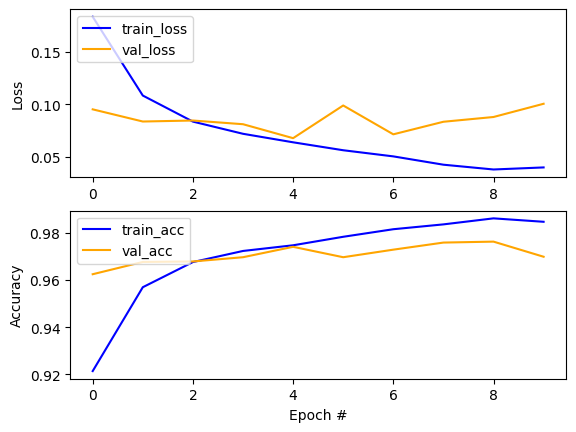

In [4]:
from matplotlib import pyplot as plt
#plot learning curves
def summarize_accuraccy_loss(history):
  # plot loss
  plt.subplot(211)
  # plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train_loss')
  plt.plot(history.history['val_loss'], color='orange', label='val_loss')
  plt.ylabel("Loss")
  plt.legend(loc="upper left")
  # plot accuracy
  plt.subplot(212)
  # plt.title('Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train_acc')
  plt.plot(history.history['val_accuracy'], color='orange', label='val_acc')
  plt.xlabel("Epoch #")
  plt.ylabel("Accuracy")
  plt.legend(loc="upper left")
  plt.show()
  plt.close()
summarize_accuraccy_loss(history)

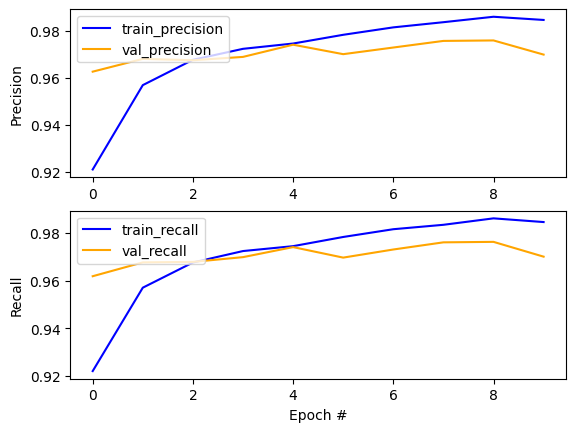

In [5]:
def summarize_precission_recall(history):
  # plot loss
  plt.subplot(211)
  # plt.title('Cross Entropy Loss')
  plt.plot(history.history['precision'], color='blue', label='train_precision')
  plt.plot(history.history['val_precision'], color='orange', label='val_precision')
  plt.ylabel("Precision")
  plt.legend(loc="upper left")
  # plot accuracy
  plt.subplot(212)
  # plt.title('Accuracy')
  plt.plot(history.history['recall'], color='blue', label='train_recall')
  plt.plot(history.history['val_recall'], color='orange', label='val_recall')
  plt.xlabel("Epoch #")
  plt.ylabel("Recall")
  plt.legend(loc="upper left")
  plt.show()
  # save plot to file
  # filename = sys.argv[0].split('/')[-1]
  # pyplot.savefig(filename + '_plot.png')
  plt.close()
summarize_precission_recall(history) 